# A Small Experiment of PU Learning

This is to understanding how PU learning works in Multi-Class Outlier Detection cases


### Setup

In [29]:
# This helps when you're loading functions defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal 
from mypackage.learning import compute_pu_scores

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## New code

In [98]:
np.random.seed(42)
# Generate data
dim = 50
mean_c1=1
mean_c2=-1
radius=4
a_signal=8

# Training data
n_in_1_train = 1000
n_in_2_train = 10

# Calibration data
n_in_1_cal = 1000
n_in_2_cal = 10

# Test data
n_in_1_test = 500
n_in_2_test = 10
n_out_test = 500

X_train, Y_train = generate_data_uniform_plus_normal(n_in_1_train, n_in_2_train, 0, dim=dim, mean_c1=mean_c1, mean_c2=mean_c2, radius=radius, a_signal=a_signal)
X_cal, Y_cal = generate_data_uniform_plus_normal(n_in_1_cal, n_in_2_cal, 0, dim=dim, mean_c1=mean_c1, mean_c2=mean_c2, radius=radius, a_signal=a_signal)
X_test, Y_test = generate_data_uniform_plus_normal(n_in_1_test, n_in_2_test, n_out_test, dim=dim, mean_c1=mean_c1, mean_c2=mean_c2, radius=radius, a_signal=a_signal)

In [99]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

# Compute conformity scores
scores_cal_2s, scores_test_2s = compute_pu_scores(X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier, two_step=True, oneclass_classifier = oneclass_classifier)        

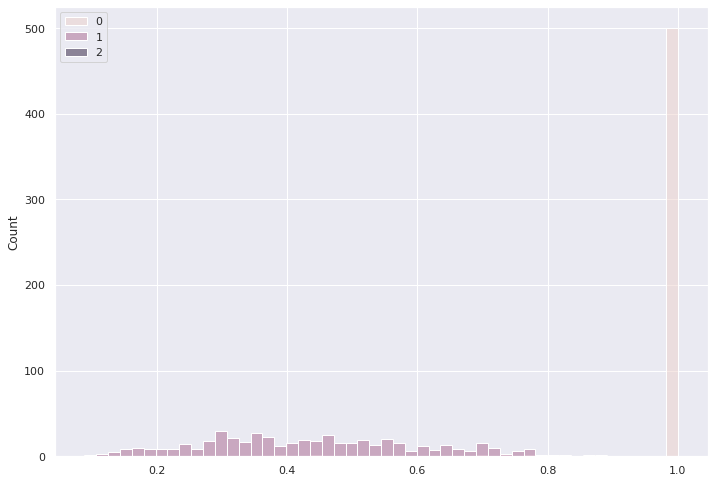

In [100]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27

sns.histplot(x=scores_test_2s, hue=Y_test, bins=50)
plt.show()

## Old code

### Data generation and visualization
Remarks: the data generation is just the same as I did last semester in the conformal inference cases

In [ ]:
np.random.seed(42)
# Generate data
dim = 50
mean_c1 = 1
mean_c2 = -1
radius = 4
a_signal = sqrt(64)

inliers_type1 = np.random.uniform(low=mean_c1 - radius, high=mean_c1 + radius, size=(50000, dim)) \
                + np.random.normal(loc=0, scale=1, size=(50000, dim))
inliers_type2 = np.random.uniform(low=mean_c2 - radius, high=mean_c2 + radius, size=(50000, dim)) \
                + np.random.normal(loc=0, scale=1, size=(50000, dim))

outlier_c1 = np.random.uniform(low=mean_c1 - radius, high=mean_c1 + radius, size=(25000, dim)) \
                       + a_signal * np.random.normal(loc=0, scale=1, size=(25000, dim))
outlier_c2 = np.random.uniform(low=mean_c2 - radius, high=mean_c2 + radius, size=(25000, dim)) \
                       + a_signal * np.random.normal(loc=0, scale=1, size=(25000, dim))
outliers = np.vstack((outlier_c1,outlier_c2))

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
inliers_type1_pca = pca.fit_transform(inliers_type1)
inliers_type2_pca = pca.fit_transform(inliers_type2)
outliers_pca = pca.fit_transform(outliers)

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.scatter(inliers_type1_pca[:1000, 0], inliers_type1_pca[:1000, 1], label='Inliers Type 1', alpha=0.5)
plt.scatter(inliers_type2_pca[:1000, 0], inliers_type2_pca[:1000, 1], label='Inliers Type 2', alpha=0.5)
plt.scatter(outliers_pca[:1000, 0], outliers_pca[:1000, 1], label='Outliers', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Data Distributions After PCA')
plt.grid(True)
plt.show()

### A standard two-step PU learning procedure function
this is a standard two step PU learning procedure dealing with guassian distributions, it contains the following steps:
1. Generate datas with three different distributions, namely type1_inliers, type2_inliers, outliers
2. Train a one class SVM on the positive training data, apply this SVM to a subset of unlabeled data, choose 10% reliable negative samples
3. Train a binary SVM on the positive training data and the reliable negative samples, apply this SVM to unlabeled test data and get the 10% samples as negative(outlier)

In [ ]:
# Function to run the PU learning procedure
def run_pu_learning(n, prop_type1_train, prop_type2_train, prop_type1_unlabeled, prop_type2_unlabeled,
                    prop_outliers_unlabeled):
    # Results storage
    results = []
    proportions_within_predictions = []
    proportions_reliable_negatives = []

    for _ in range(n):
        iteration = _
        # Sample 1000 data points for training
        X_train_pos1, X_test_inliers1, _, _ = train_test_split(inliers_type1, np.zeros(50000),
                                                               train_size=int(2000 * prop_type1_train),
                                                               test_size=int(1000 * 2 * prop_type1_unlabeled))
        X_train_pos2, X_test_inliers2, _, _ = train_test_split(inliers_type2, np.zeros(50000),
                                                               train_size=int(2000 * prop_type2_train),
                                                               test_size=int(1000 * 2 * prop_type2_unlabeled))
        X_train = np.vstack((X_train_pos1, X_train_pos2))

        # Ensure balanced representation of inliers in unlabeled data
        X_unlabeled_inliers1, X_test_pos1, _, _ = train_test_split(X_test_inliers1,
                                                                   np.zeros(int(1000 * 2 * prop_type1_unlabeled)),
                                                                   train_size=int(1000 * prop_type1_unlabeled),
                                                                   test_size=int(1000 * prop_type1_unlabeled))
        X_unlabeled_inliers2, X_test_pos2, _, _ = train_test_split(X_test_inliers2,
                                                                   np.zeros(int(1000 * 2 * prop_type2_unlabeled)),
                                                                   train_size=int(1000 * prop_type2_unlabeled),
                                                                   test_size=int(1000 * prop_type2_unlabeled))
        X_unlabeled_outliers, X_test_neg, _, _ = train_test_split(outliers, np.zeros(50000),
                                                                  train_size=int(1000 * prop_outliers_unlabeled),
                                                                  test_size=int(1000 * prop_outliers_unlabeled))
        X_unlabeled = np.vstack((X_unlabeled_inliers1, X_unlabeled_inliers2, X_unlabeled_outliers))

        # Combine testing data
        X_test = np.vstack((X_test_pos1, X_test_pos2, X_test_neg))
        y_test = np.hstack((np.zeros(len(X_test_pos1) + len(X_test_pos2)), np.ones(len(X_test_neg))))

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_unlabeled_scaled = scaler.transform(X_unlabeled)
        X_test_scaled = scaler.transform(X_test)

        # Step 1: Train a one-class SVM on positive samples
        one_class_svm = OneClassSVM(gamma='auto').fit(X_train_scaled)

        # Apply the one-class SVM to the unlabeled data
        pred_unlabeled = one_class_svm.predict(X_unlabeled_scaled)
        reliable_negatives_idx = np.where(pred_unlabeled == -1)[0]  # Select reliable negatives
        X_reliable_negatives = X_unlabeled_scaled[reliable_negatives_idx]

        # Combine the positive samples with reliable negatives
        X_combined = np.vstack((X_train_scaled, X_reliable_negatives))
        y_combined = np.hstack((np.zeros(len(X_train_scaled)), np.ones(len(X_reliable_negatives))))

        # Step 2: Train a binary classifier on the selected positives and reliable negatives
        final_clf = SVC(probability=True)
        final_clf.fit(X_combined, y_combined)

        # After fitting final_clf, predict probabilities
        predictions_prob = final_clf.predict_proba(X_test_scaled)

        # Adjust the threshold to achieve 50% predictions as 1
        predictions = (predictions_prob[:, 1] >= 0.5).astype(int)

        # Calculate FDR and Power
        false_positives = np.sum((predictions == 1) & (y_test == 0))
        true_positives = np.sum((predictions == 1) & (y_test == 1))
        total_predictions = np.sum(predictions == 1)

        fdr = false_positives / total_predictions if total_predictions > 0 else 0
        power = true_positives / np.sum(y_test == 1) if np.sum(y_test == 1) > 0 else 0

        print(f"Iteration {iteration}")
        print(f"prop_type1_train:  {prop_type1_train}")
        print(f"prop_type1_unlabeled:  {prop_type1_unlabeled}")
        print(f"fdr:  {fdr}")
        print(f"power: {power}")

        # Calculate proportions of type1, type2 inliers and outliers within predictions = 1
        type1_pred = np.sum(predictions[:len(X_test_pos1)] == 1)
        type2_pred = np.sum(predictions[len(X_test_pos1):len(X_test_pos1) + len(X_test_pos2)] == 1)
        outliers_pred = np.sum(predictions[len(X_test_pos1) + len(X_test_pos2):] == 1)

        total_pred = type1_pred + type2_pred + outliers_pred
        prop_type1_pred = type1_pred / total_pred if total_pred > 0 else 0
        prop_type2_pred = type2_pred / total_pred if total_pred > 0 else 0
        prop_outliers_pred = outliers_pred / total_pred if total_pred > 0 else 0

        proportions_within_predictions.append((prop_type1_pred, prop_type2_pred, prop_outliers_pred))

        results.append((fdr, power))

    return results, proportions_within_predictions


### Change the proportion of type1 data in both positive set and unlabeled set

In [ ]:
# Parameters
n = 20  # Number of iterations
prop_type1_train_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
prop_type1_unlabeled_values = [0.5, 0.95, 0.99]  # Only extreme conditions
prop_outliers = 0.1

# Adjusted proportion combinations
proportion_combinations = []
for p1_train in prop_type1_train_values:
    for p1_unlabeled in prop_type1_unlabeled_values:
        p2_train = 1 - p1_train
        p2_unlabeled = 1 - p1_unlabeled

        proportion_combinations.append((p1_train, p2_train, p1_unlabeled, p2_unlabeled, prop_outliers))

In [ ]:
# Run the PU learning procedure for each combination of proportions
all_results = {}
all_proportions = {}
for props in proportion_combinations:
    prop_type1_train, prop_type2_train, prop_type1_unlabeled, prop_type2_unlabeled, prop_outliers_unlabeled = props
    results, proportions_within_predictions = run_pu_learning(n, prop_type1_train, prop_type2_train,
                                                              prop_type1_unlabeled, prop_type2_unlabeled,
                                                              prop_outliers_unlabeled)
    all_results[props] = results
    all_proportions[props] = proportions_within_predictions

### Plot

In [ ]:
# Prepare data for plotting
fdr_means = []
power_means = []
fdr_stds = []
power_stds = []
proportion_labels = []
prop_type1_preds = []
prop_type2_preds = []
prop_outliers_preds = []

for props, results in all_results.items():
    fdrs, powers = zip(*results)
    fdr_means.append(np.mean(fdrs))
    power_means.append(np.mean(powers))
    fdr_stds.append(np.std(fdrs) / sqrt(n))
    power_stds.append(np.std(powers) / sqrt(n))
    proportion_labels.append((props[0], props[2]))  # Using prop_type1_train and prop_type1_unlabeled for x-axis

    type1_props, type2_props, outlier_props = zip(*all_proportions[props])
    prop_type1_preds.append(np.mean(type1_props))
    prop_type2_preds.append(np.mean(type2_props))
    prop_outliers_preds.append(np.mean(outlier_props))

In [ ]:
# Plot the results in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(21, 24))

for i, p1_unlabeled in enumerate(prop_type1_unlabeled_values):
    # Filter results for the current prop_type1_unlabeled value
    fdr_means_subset = [fdr_means[j] for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled]
    power_means_subset = [power_means[j] for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled]
    fdr_stds_subset = [fdr_stds[j] for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled]
    power_stds_subset = [power_stds[j] for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled]

    prop_type1_preds_subset = [prop_type1_preds[j] for j, props in enumerate(proportion_combinations) if
                               props[2] == p1_unlabeled]
    prop_type2_preds_subset = [prop_type2_preds[j] for j, props in enumerate(proportion_combinations) if
                               props[2] == p1_unlabeled]
    prop_outliers_preds_subset = [prop_outliers_preds[j] for j, props in enumerate(proportion_combinations) if
                                  props[2] == p1_unlabeled]

    # Plot FDR
    ax = axes[0, i]
    ax.errorbar(range(len(fdr_means_subset)), fdr_means_subset, yerr=fdr_stds_subset, fmt='o', linestyle='--',
                label='FDR')
    ax.set_xticks(range(len(fdr_means_subset)))
    ax.set_xticklabels([f"{props[0]}" for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled],
                       rotation=45)
    ax.set_xlabel('Proportion of Type 1 in Positive Training Data')
    ax.set_ylabel('FDR')
    ax.set_title(f'FDR (prop_type1_unlabeled = {p1_unlabeled})')
    ax.grid(True)

    # Plot Power
    ax = axes[1, i]
    ax.errorbar(range(len(power_means_subset)), power_means_subset, yerr=power_stds_subset, fmt='o', linestyle='--',
                label='Power')
    ax.set_xticks(range(len(power_means_subset)))
    ax.set_xticklabels([f"{props[0]}" for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled],
                       rotation=45)
    ax.set_xlabel('Proportion of Type 1 in Positive Training Data')
    ax.set_ylabel('Power')
    ax.set_title(f'Power (prop_type1_unlabeled = {p1_unlabeled})')
    ax.grid(True)

    # Plot Proportions within predictions = 1
    ax = axes[2, i]
    ax.plot(range(len(prop_type1_preds_subset)), prop_type1_preds_subset, 'o-', label='Type 1 Inliers')
    ax.plot(range(len(prop_type2_preds_subset)), prop_type2_preds_subset, 'o-', label='Type 2 Inliers')
    ax.plot(range(len(prop_outliers_preds_subset)), prop_outliers_preds_subset, 'o-', label='Outliers')
    ax.set_xticks(range(len(prop_type1_preds_subset)))
    ax.set_xticklabels([f"{props[0]}" for j, props in enumerate(proportion_combinations) if props[2] == p1_unlabeled],
                       rotation=45)
    ax.set_xlabel('Proportion of Type 1 in Positive Training Data')
    ax.set_ylabel('Proportion within Predictions = 1')
    ax.set_title(f'Predictions = 1 (prop_type1_unlabeled = {p1_unlabeled})')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

### Conclusion
1. When the proportion of type1 data is small in training data, then PU learning tends to regard inliers as negative in the unlabeled dataset
2. The results depend heavily on the “fit” between the machine learning algorithm and the data. (Compared to the conformal inference experiment, it **regards every data as negative** if outliers are not so obvious and was't been standard scaled)|

#### Puzzle(solved):
1. Why FDR is so high?
   the data is almost the same in my previous experiment in the conformal inference cases. However, FDR here is very high.
   
**Possible Explannation**: the two-step PUL double the prediction error, since it first introduce one-class svm to identify some reliable negative data, and use it to train a binary classifier.(double error)